In [1]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import math
import sqlite3
from bs4 import BeautifulSoup
from nltk.corpus import stopwords,wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
con=sqlite3.connect('database.sqlite')

In [3]:
filtered_data=pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score !=3 LIMIT 50000""",con)

In [4]:
filtered_data.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
49995,54290,B004V3INB0,A11F42B0Q3ET89,baxter,0,0,4,1330905600,jamaica me crazy k-cups/flavor,i had taste tested this when a friend gave a c...
49996,54291,B004V3INB0,AFHBO1FR7COBF,"Atypical Soccer Mom ""cook, teacher, personal ...",0,0,1,1327708800,Not Comparable to Green Mountain Coffee Roaste...,I bought this coffee in the hopes that it woul...
49997,54292,B004V3INB0,A18UUSTSQJYK8O,"Tamra L. Bowman ""tamrabear""",0,0,5,1319673600,My favorite..... I can't live without it !,I'm going to go broke drinking these. I disco...
49998,54293,B004V3INB0,A3E2QMBUB7VQOI,Nola Belle,0,0,5,1311465600,Pretty Good,"Reviews for coffee can be hard, because everyo..."
49999,54294,B004V3INB0,A3AZI828WJN1CD,Becky (beckygardens),0,0,1,1311120000,Nasty,This tasted like the cheapest fake coconut tas...


In [5]:
def partition(x):
    if x < 3:
        return 0
    return 1
actualdata=filtered_data['Score']
positivenegative=actualdata.map(partition)
filtered_data['Score']=positivenegative
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
#display count > 1 which means duplicates
display=pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Text, Score, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""",con)

In [7]:
display.head()

,UserId,ProductId,ProfileName,Time,Text,Score,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,Overall its just OK when considering the price...,2,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,"My wife has recurring extreme muscle spasms, u...",5,3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,This coffee is horrible and unfortunately not ...,1,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,This will be the bottle that you grab from the...,5,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,I didnt like this coffee. Instead of telling y...,1,2


In [8]:
sort_data=filtered_data.sort_values('ProductId',axis=0,inplace=False,ascending=True,kind='quicksort')

In [9]:
final=sort_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},inplace=False,keep='first')

In [10]:
final.shape

(46072, 10)

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
final.shape

(46071, 10)

In [13]:
final['Score'].value_counts()

1    38479
0     7592
Name: Score, dtype: int64

In [14]:
#Text preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
from tqdm import tqdm
cleaned_reviews=[]
for sentence in tqdm(final['Text'].values):
    sentence=re.sub(r"http\S+","",sentence)#removing url tags
    sentence=BeautifulSoup(sentence,"lxml").get_text()#removing html tags
    sentence=decontracted(sentence)#decontracting words
    sentence=re.sub("\S*\d\S*", "",sentence).strip()#removing words with numbers
    sentence=re.sub("[^A-Za-z0-9]+", " ", sentence)#removing special character
    sentence=" ".join(x.lower() for x in sentence.split() if x.lower() not in stopwords)
    cleaned_reviews.append(sentence.strip())
    

100%|██████████| 46071/46071 [00:30<00:00, 1516.94it/s]


In [17]:
cleaned_reviews[500]

'good fruit slices flavor tart not sweet dusting sugar good left get little solid not gel like'

In [18]:
cleaned_summary=[]
for sentence in tqdm(final['Summary'].values):
    sentence=re.sub(r"http\S+","",sentence)#removing url tags
    sentence=BeautifulSoup(sentence,"lxml").get_text()#removing html tags
    sentence=decontracted(sentence)#decontracting words
    sentence=re.sub("\S*\d\S*", "",sentence).strip()#removing words with numbers
    sentence=re.sub("[^A-Za-z0-9]+", " ", sentence)#removing special character
    sentence=" ".join(x.lower() for x in sentence.split() if x.lower() not in stopwords)
    cleaned_summary.append(sentence.strip())

100%|██████████| 46071/46071 [00:18<00:00, 2458.35it/s]


In [19]:
cleaned_summary[500]

'great flavor'

# K-d Tree Bag Of Words

In [20]:
from sklearn.neighbors import KNeighborsClassifier

In [21]:
X=cleaned_reviews
y=np.array(final['Score'])

In [22]:
X_1,X_test,y_1,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
X_train,X_cv,y_train,y_cv=train_test_split(X_1,y_1,test_size=0.3)

In [23]:
count_bow=CountVectorizer()
finalX_train=count_bow.fit_transform(X_train)
finalX_cv=count_bow.transform(X_cv)
finalX_test=count_bow.transform(X_test)

In [24]:
finalX_train

<22574x28232 sparse matrix of type '<class 'numpy.int64'>'
	with 738174 stored elements in Compressed Sparse Row format>

In [25]:
finalX_cv

<9675x28232 sparse matrix of type '<class 'numpy.int64'>'
	with 313603 stored elements in Compressed Sparse Row format>

In [26]:
finalX_test

<13822x28232 sparse matrix of type '<class 'numpy.int64'>'
	with 443038 stored elements in Compressed Sparse Row format>

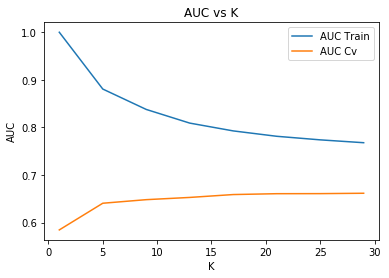

In [33]:
auc_train=[]
auc_cv=[]
cv_score=[]
K=list(range(1,30,4))
for i in K:
    knn=KNeighborsClassifier(n_neighbors=i,weights='uniform',algorithm='kd_tree',leaf_size=30,p=2)
    knn.fit(finalX_train,y_train)
    predi=knn.predict_proba(finalX_cv)[:,1]
    auc_cv.append(roc_auc_score(y_cv,predi))
    predi1=knn.predict_proba(finalX_train)[:,1]
    auc_train.append(roc_auc_score(y_train,predi1))
    
fig=plt.figure()
ax=plt.subplot(111)
ax.plot(K,auc_train,label='AUC Train')
ax.plot(K,auc_cv,label='AUC Cv')
plt.title("AUC vs K")
plt.xlabel('K')
plt.ylabel("AUC")
plt.legend()
plt.show()

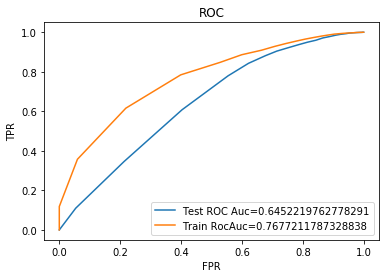

In [34]:
#k=29
from sklearn import metrics
knn=KNeighborsClassifier(n_neighbors=29,weights='uniform',p=2,algorithm='kd_tree')
knn.fit(finalX_train,y_train)
predi=knn.predict_proba(finalX_test)[:,1]
fpr1,tpr1,threshold=metrics.roc_curve(y_test,predi)
pred1=knn.predict_proba(finalX_train)[:,1]
fpr2,tpr2,threshold2=metrics.roc_curve(y_train,pred1)
fig=plt.figure()
ax=plt.subplot(111)
ax.plot(fpr1,tpr1,label="Test ROC Auc="+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2,tpr2,label="Train RocAuc="+str(roc_auc_score(y_train,pred1)))
plt.xlabel("FPR")
plt.ylabel('TPR')
plt.title('ROC')
plt.legend()
plt.show()

In [35]:
#confusion matrix
knn=KNeighborsClassifier(n_neighbors=29,p=2,weights='uniform',algorithm='kd_tree')
knn.fit(finalX_train,y_train)
predict=knn.predict(finalX_test)

In [36]:
cm=confusion_matrix(y_test,predict)

In [37]:
cm

array([[  171,  2070],
       [  123, 11458]], dtype=int64)

In [38]:
acu=accuracy_score(y_test,predict)*100

In [39]:
acu

84.13398929243236

# kd tree on TF-IDF

In [40]:
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2),min_df=10)
X_2,X_test2,y_2,y_test2=train_test_split(X,y,test_size=0.3,random_state=0)
X_tr_2,X_cv_2,y_tr_2,y_cv_2=train_test_split(X_2,y_2,test_size=0.3)

In [41]:
final_Xtr_2=tf_idf_vect.fit_transform(X_tr_2)
final_Xcv_2=tf_idf_vect.transform(X_cv_2)
final_Xtest_2=tf_idf_vect.transform(X_test2)

In [42]:
auc_cv=[]
auc_train=[]
K=[]
for i in range(1,50,4):
    knn=KNeighborsClassifier(n_neighbors=i,weights='uniform',algorithm='kd_tree',leaf_size=30, p=2)
    knn.fit(final_Xtr_2, y_tr_2)
    pred_2 = knn.predict_proba(final_Xcv_2)[:,1]
    pred_1=knn.predict_proba(final_Xtr_2)[:,1]
    auc_cv.append(roc_auc_score(y_cv_2,pred_2))
    auc_train.append(roc_auc_score(y_tr_2,pred_1))
    K.append(i)

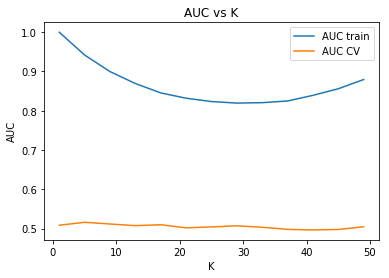

In [43]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(K, auc_train, label='AUC train')
ax.plot(K, auc_cv, label='AUC CV')
plt.title('AUC vs K')
plt.xlabel('K')
plt.ylabel('AUC')
ax.legend()
plt.show()

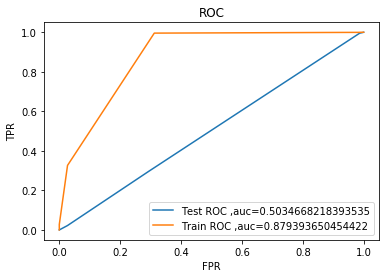

In [44]:
#for k =49
knn=KNeighborsClassifier(n_neighbors=49,weights='uniform',algorithm='kd_tree',leaf_size=30, p=2)
knn.fit(final_Xtr_2,y_tr_2)
predi=knn.predict_proba(final_Xtest_2)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test2, predi)
pred=knn.predict_proba(final_Xtr_2)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_tr_2,pred)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc='+str(roc_auc_score(y_test2,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc='+str(roc_auc_score(y_tr_2,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

In [47]:
#confusion matrix
knn=KNeighborsClassifier(n_neighbors=49,weights='uniform',algorithm='kd_tree',leaf_size=30, p=2)
knn.fit(final_Xtr_2,y_tr_2)
predic=knn.predict(final_Xtest_2)
cm=confusion_matrix(y_test2,predic)
cm

array([[    0,  2241],
       [    0, 11581]], dtype=int64)

In [48]:
accu=accuracy_score(y_test2,predic)*100
accu

83.78671682824482

In [49]:
#Feature engineering
for i in range(len(cleaned_reviews)):
    cleaned_reviews[i]+=' '+cleaned_summary[i]+' '+str(len(final.Text.iloc[i]))

cleaned_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based gym rat bargain 278'

In [50]:
#apply this feature eng to the data and perform Bag of Words and TF-IDF